# EDA and Clustering Project

course: **Fundamentals of Machine Learning**

dataset: Audi used car listings

by: Bohdan Kulčyckyj



---



Import packages

In [162]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.6 MB/s eta 0:00:00


In [165]:
import hdbscan
import numpy as np
import pandas as pd
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

### EDA

#### Initial Overview

Load the data

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/bohdanKulcyckyj/eda_and_clustering_on_audi_dataset/refs/heads/main/audi.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


Dataset shape (rows, cols)

In [37]:
df.shape

(10668, 9)

Find out column data types

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


There are 6 numeric and 3 object values. Object values should be processed later before clustering, but for now let's leave them as they are.

Check for NULL values in dataset

In [36]:
df.isna().sum().sort_values(ascending=False)

,0
model,0
year,0
price,0
transmission,0
mileage,0
fuelType,0
tax,0
mpg,0
engineSize,0


**No NULL values found**

Lets take a look at different Models and count their occurences

In [27]:
df["model"].value_counts()

,count
model,
A3,1929
Q3,1417
A4,1381
A1,1347
A5,882
Q5,877
Q2,822
A6,748
Q7,397


Let's do the same for Transmission

In [28]:
df["transmission"].value_counts()

,count
transmission,
Manual,4369
Semi-Auto,3591
Automatic,2708


and also for Fuel Type

In [29]:
df["fuelType"].value_counts()

,count
fuelType,
Diesel,5577
Petrol,5063
Hybrid,28


#### Dataset description

**model** - audi model<br>
**year** - registraion year<br>
**price** - price in Euros<br>
**transmission** - type of gear box<br>
**mileage** - distance used<br>
**fuelType** - engine fuel<br>
**tax** - road tax<br>
**mpg** - miles per galoon<br>
**engineSize** - size in litres<br>

In [31]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


The dataset contains information about Audi cars registered between 1997 and 2020, with most being newer models. It includes details such as year, price, mileage, road tax, fuel efficiency (MPG), and engine size. Cars have either Manual, Semi-Automatic, or Automatic transmission and use Diesel, Petrol, or Hybrid fuel types.

#### Hypotheses

<Figure size 1200x900 with 0 Axes>

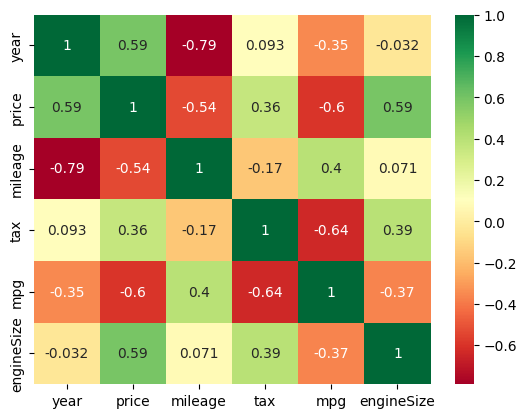

<Figure size 1200x900 with 0 Axes>

In [107]:
selected_columns = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
corr_matrix = df[selected_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn")
plt.figure(figsize=(12, 9))

##### 1. Newer cars are priced higher

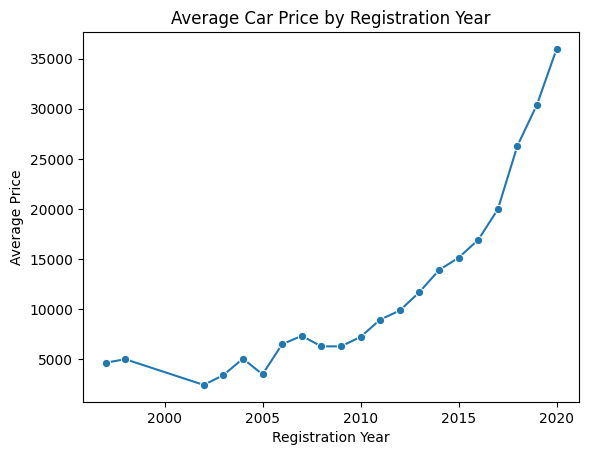

In [42]:
mean_prices = df.groupby('year')['price'].mean().reset_index()

sns.lineplot(x='year', y='price', data=mean_prices, marker='o')
plt.title('Average Car Price by Registration Year')
plt.xlabel('Registration Year')
plt.ylabel('Average Price')
plt.show()


The average price tends to rise


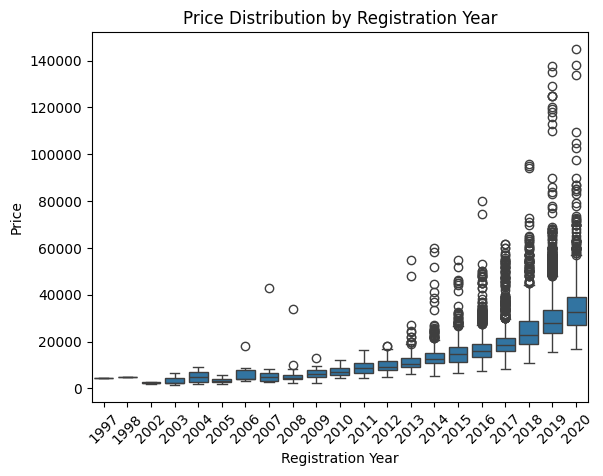

In [44]:
sns.boxplot(x='year', y='price', data=df)
plt.title('Price Distribution by Registration Year')
plt.xlabel('Registration Year')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

The median line in the box plot rising as year increases.


**The hypothesis that newer cars are priced higher is supported by the data.**

##### 2. Cars with higher mileage are priced lower

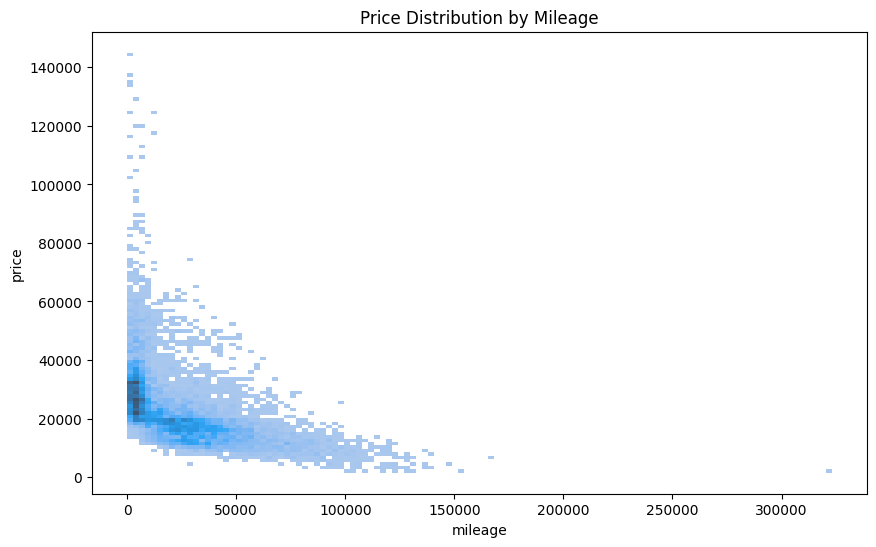

In [85]:
fig = plt.figure(figsize = (10,6))
sns.histplot(data = df, x = "mileage", y = "price", multiple="stack")
plt.title('Price Distribution by Mileage')
plt.show()

<Axes: >

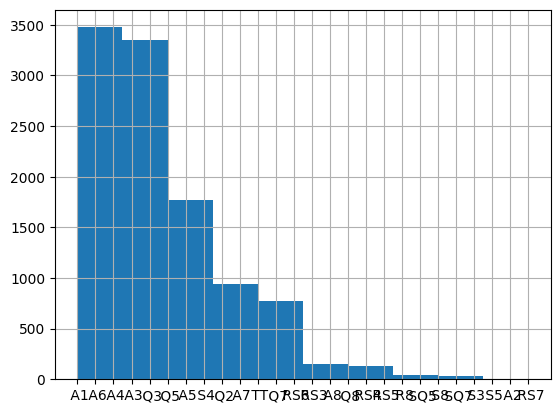

In [86]:
df["model"].hist()

Lets try to plot the mileage-price relationship for each model, which has at least 100 rows and filter out outliers

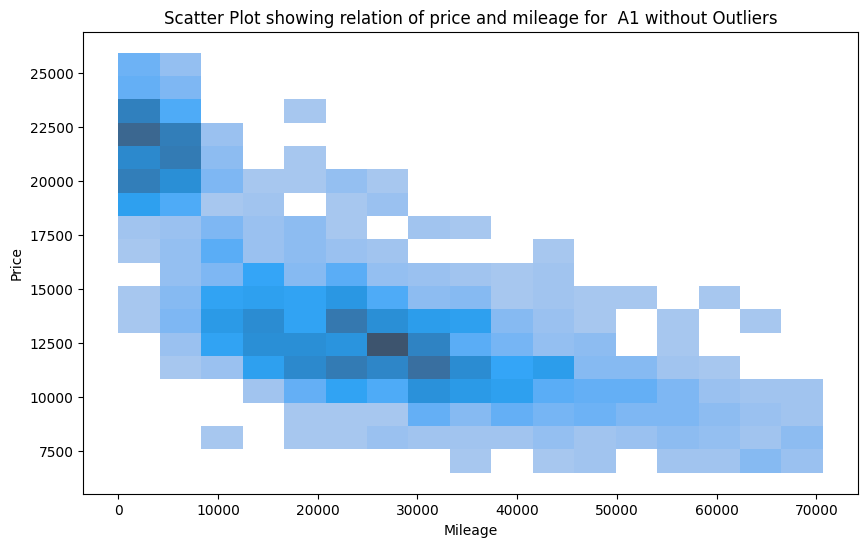

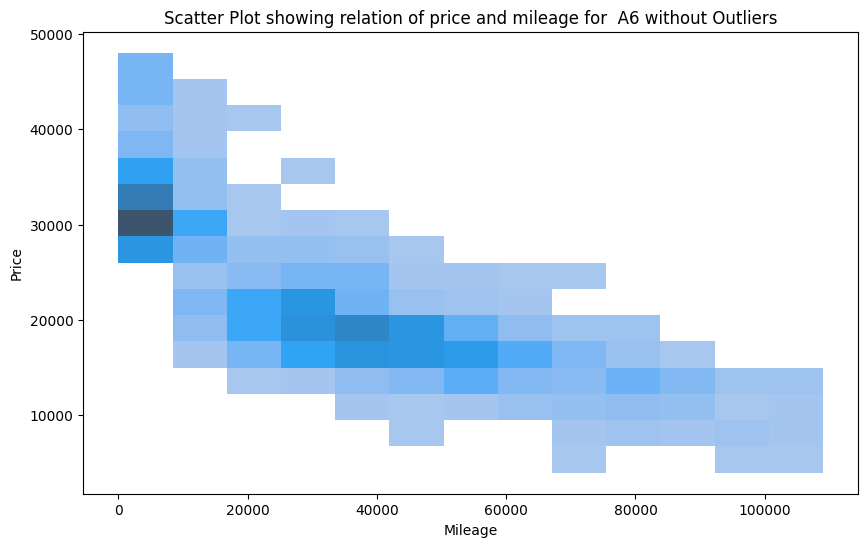

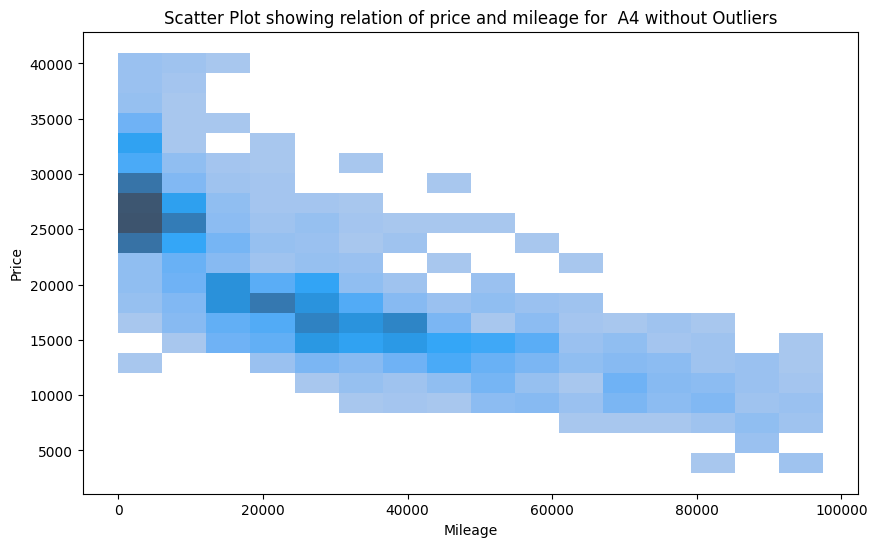

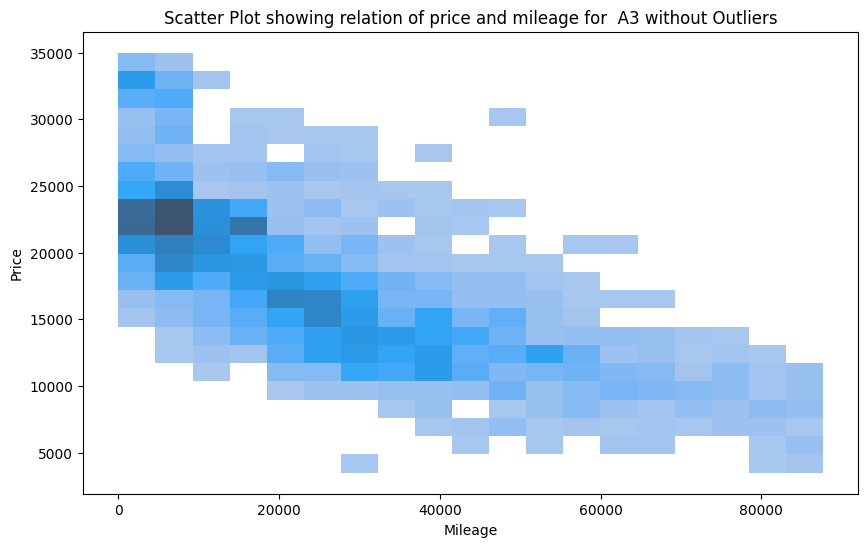

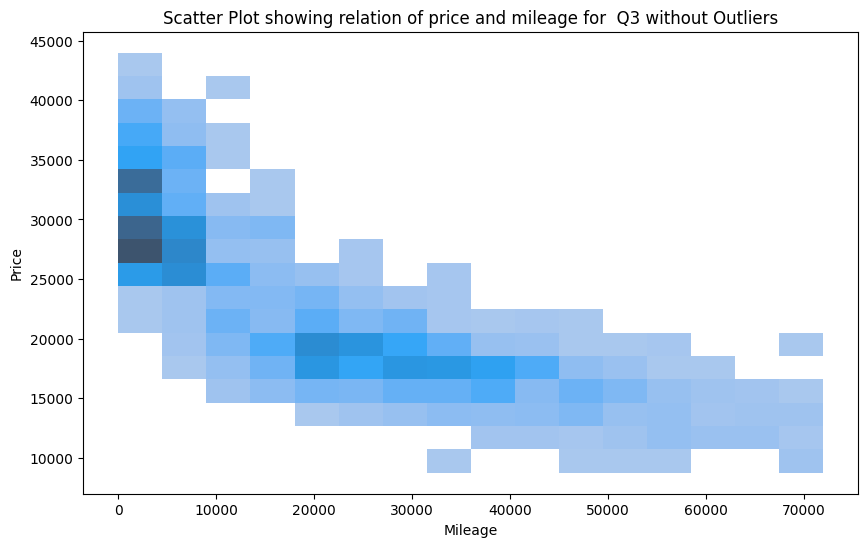

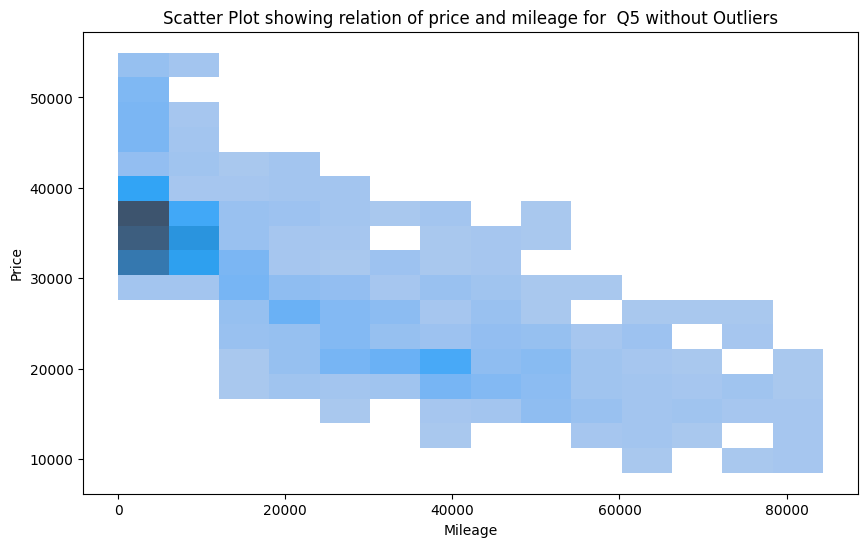

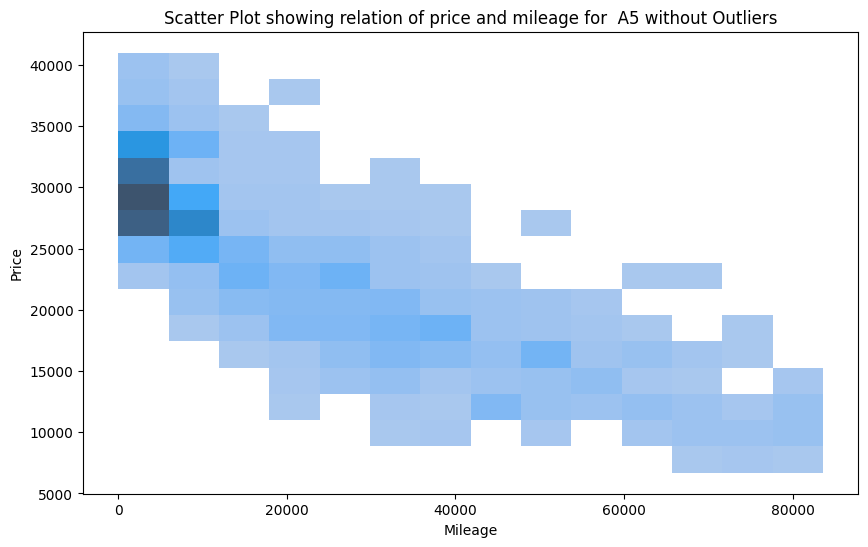

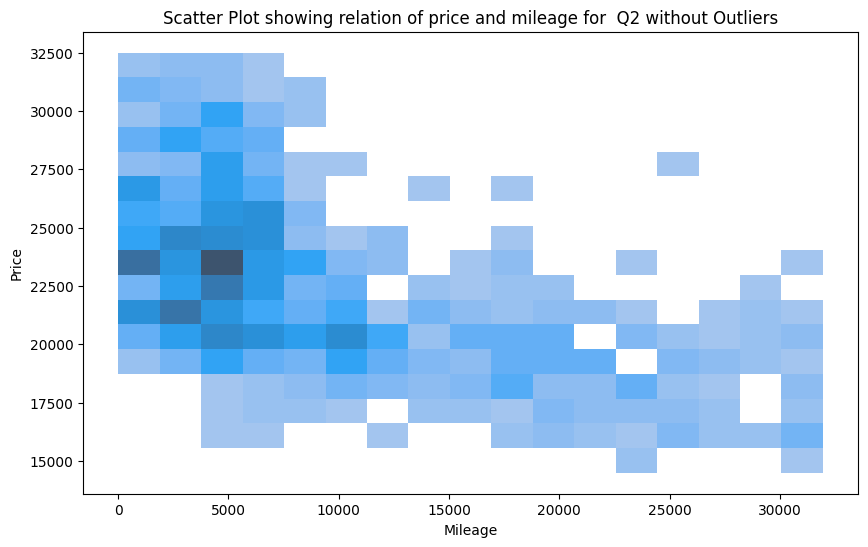

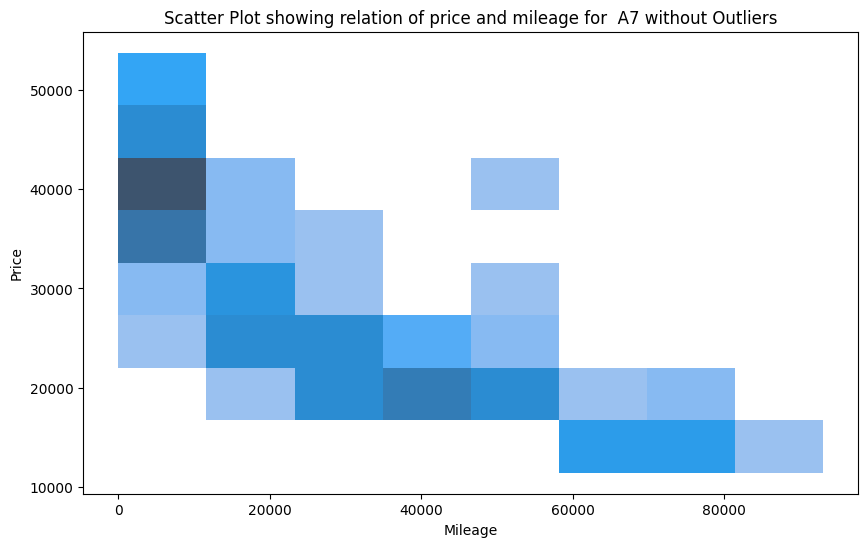

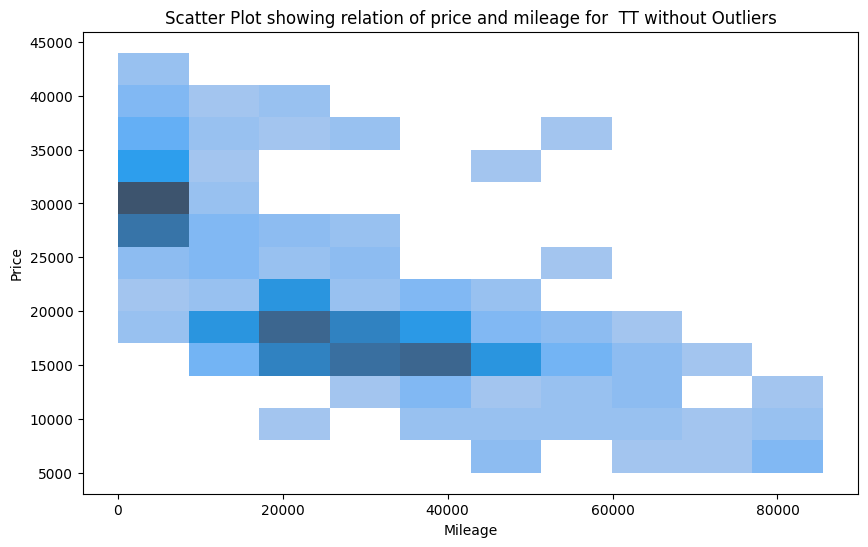

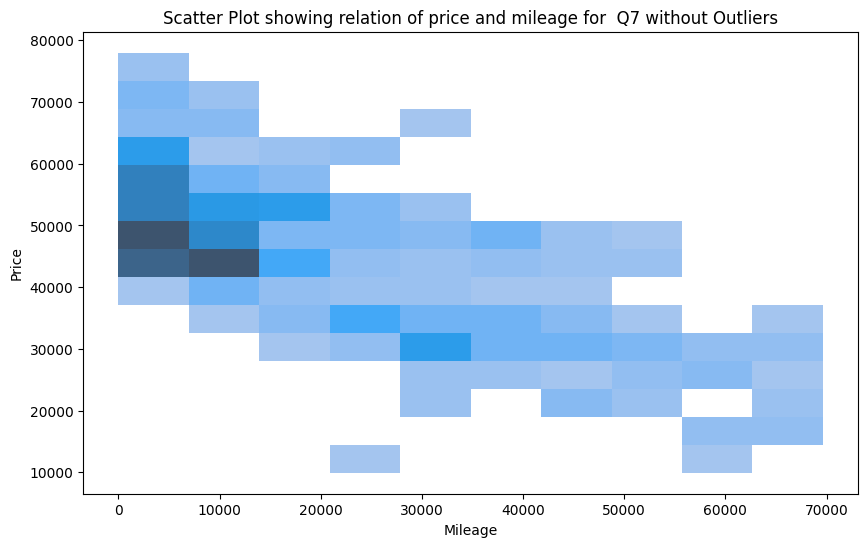

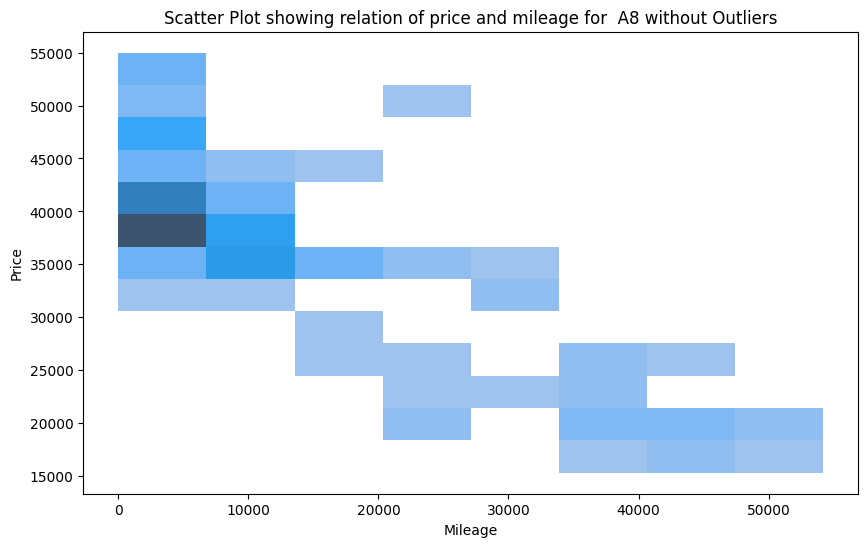

In [87]:
for model in df['model'].unique():
  df_model = df[df['model'] == model]
  rows, columns =df_model.shape
  if rows < 100:
    continue

  mileage_quantiles = df_model['mileage'].quantile([0.25, 0.75])
  mileage_irq = mileage_quantiles[0.75] - mileage_quantiles[0.25]
  mileage_lower_bound = mileage_quantiles[0.25] - 1.5 * mileage_irq
  mileage_upper_bound = mileage_quantiles[0.75] + 1.5 * mileage_irq

  price_quantiles = df_model['price'].quantile([0.25, 0.75])
  price_irq = price_quantiles[0.75] - price_quantiles[0.25]
  price_lower_bound = price_quantiles[0.25] - 1.5 * price_irq
  price_upper_bound = price_quantiles[0.75] + 1.5 * price_irq

  df_without_outliers = df_model[
    (df_model['mileage'] >= mileage_lower_bound) &
    (df_model['mileage'] <= mileage_upper_bound) &
    (df_model['price'] >= price_lower_bound) &
    (df_model['price'] <= price_upper_bound)
  ]

  plt.figure(figsize=(10, 6))
  sns.histplot(data = df_without_outliers, x = "mileage", y = "price", multiple="stack")
  plt.xlabel('Mileage')
  plt.ylabel('Price')
  plt.title(f"Scatter Plot showing relation of price and mileage for {model} without Outliers")
  plt.show()

**The hypothesis that cars with higher mileage are priced lower is supported by the data.**

##### 3. Diesel Cars Have Better Fuel Efficiency (Higher MPG) Than Petrol Cars

In [91]:
df["fuelType"].value_counts()

,count
fuelType,
Diesel,5577
Petrol,5063
Hybrid,28


There are almost as many diesel cars as petrol in the dataset.

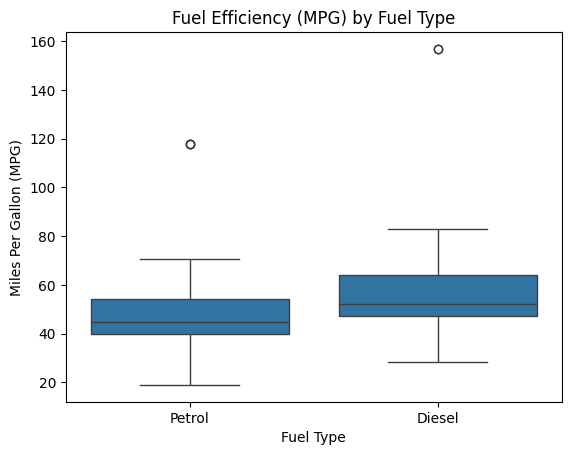

In [88]:
df_diesel_or_petrol = df[df['fuelType'].isin(['Diesel', 'Petrol'])]
sns.boxplot(x='fuelType', y='mpg', data=df_diesel_or_petrol)
plt.title('Fuel Efficiency (MPG) by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Miles Per Gallon (MPG)')
plt.show()

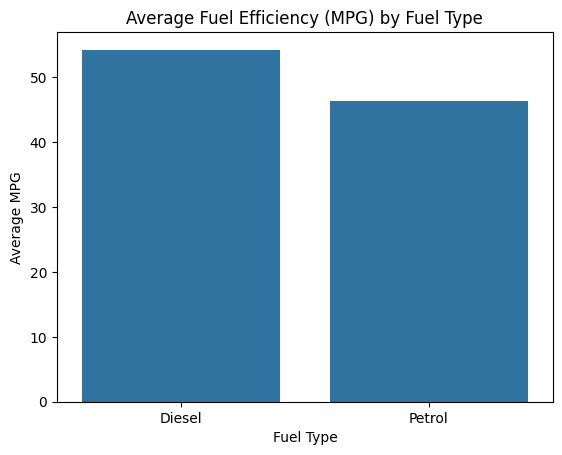

In [89]:
mean_mpg = df_diesel_or_petrol.groupby('fuelType')['mpg'].mean().reset_index()

# Bar chart for mean MPG
sns.barplot(x='fuelType', y='mpg', data=mean_mpg)
plt.title('Average Fuel Efficiency (MPG) by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average MPG')
plt.show()

**The hypothesis that diesel cars have better fuel efficiency (higher MPG) than petrol cars is supported by the data.**

##### 4. Cars with larger engine sizes have higher tax rates

In [96]:
df["engineSize"].value_counts()

,count
engineSize,
2.0,5169
1.4,1594
3.0,1149
1.6,913
1.5,744
1.0,558
4.0,154
1.8,126
2.5,61


Filter out engineSize with less than 100 rows

In [98]:
engineSize_counts = df["engineSize"].value_counts()
filtered_engineSize_counts_values = engineSize_counts[engineSize_counts >= 100].index.tolist()
filtered_engineSize_counts_df = df[df['engineSize'].isin(filtered_engineSize_counts_values)]

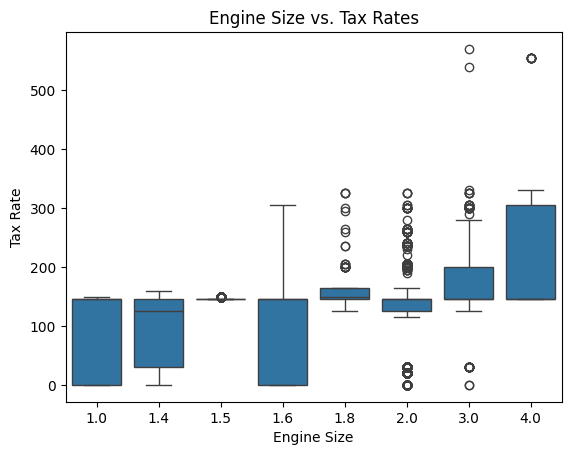

In [103]:
sns.boxplot(x='engineSize', y='tax', data=filtered_engineSize_counts_df)
plt.title('Engine Size vs. Tax Rates')
plt.xlabel('Engine Size')
plt.ylabel('Tax Rate')
plt.show()

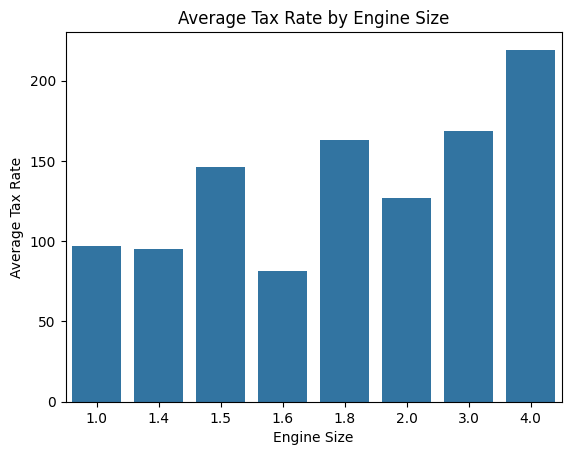

In [101]:
engine_tax_group = filtered_engineSize_counts_df.groupby('engineSize')['tax'].mean().reset_index()

sns.barplot(x='engineSize', y='tax', data=engine_tax_group)
plt.title('Average Tax Rate by Engine Size')
plt.xlabel('Engine Size')
plt.ylabel('Average Tax Rate')
plt.show()


In [105]:
correlation = filtered_engineSize_counts_df['engineSize'].corr(filtered_engineSize_counts_df['tax'])
print(f"Correlation between engine size and tax: {correlation}")

Correlation between engine size and tax: 0.36026174347986184


**The coefficient indicates a moderate positive correlation The relationship exists but is not strong enough to confidently state that engine size alone determines tax rates.**

##### 5. Correlation between engine size and mpg

<Axes: xlabel='engineSize', ylabel='mpg'>

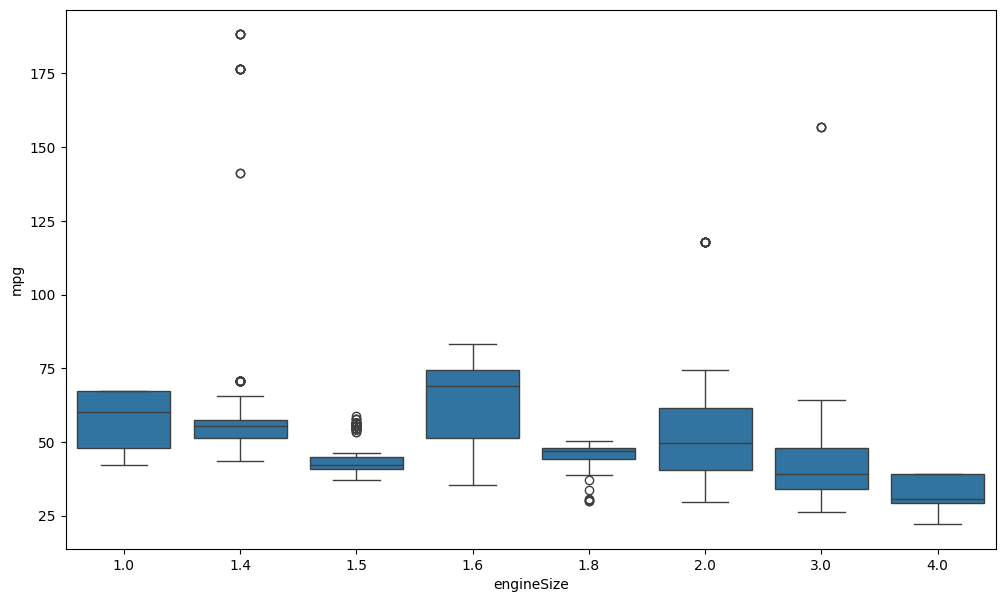

In [106]:
fig = plt.figure(figsize=(12,7))
sns.boxplot(data = filtered_engineSize_counts_df, x = "engineSize", y = "mpg")

**Cars with larger engine sizes, such as 3.0 and 4.0 liters, show significantly lower fuel efficiency, with MPG dropping to around 30-40, while smaller engines, like 1.6 liters, perform much better, achieving up to 60 MPG. Hypothesis disproved.**

### Clustering analysis

#### K-Means

In [150]:
df_clustering = df.copy()
df_clustering.describe(include=np.number)

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


In [151]:
df_clustering.describe(exclude=np.number)

,model,transmission,fuelType
count,10668,10668,10668
unique,26,3,3
top,A3,Manual,Diesel
freq,1929,4369,5577


The dataset contains three string columns that need to be converted to numerical values. For transmission and fuelType, which have only three unique values each, integer encoding would work just fine. However, the model column has 26 unique values, making integer encoding less ideal. On the other hand, one-hot encoding could be used, though it creates a large number of columns. Given that the dataset has only nine columns, adding more columns with one-hot encoding shouldn’t be too problematic.

In [152]:
df_encoded = pd.get_dummies(df_clustering)
df_encoded.dtypes

,0
year,int64
price,int64
mileage,int64
tax,int64
mpg,float64
engineSize,float64
model_ A1,bool
model_ A2,bool
model_ A3,bool
model_ A4,bool


In [153]:
df_encoded.head()

,year,price,mileage,tax,mpg,engineSize,model_ A1,model_ A2,model_ A3,model_ A4,...,model_ S8,model_ SQ5,model_ SQ7,model_ TT,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,2017,12500,15735,150,55.4,1.4,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,2016,16500,36203,20,64.2,2.0,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
2,2016,11000,29946,30,55.4,1.4,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
3,2017,16800,25952,145,67.3,2.0,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
4,2019,17300,1998,145,49.6,1.0,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True


##### Elbow method

<Axes: xlabel='k'>

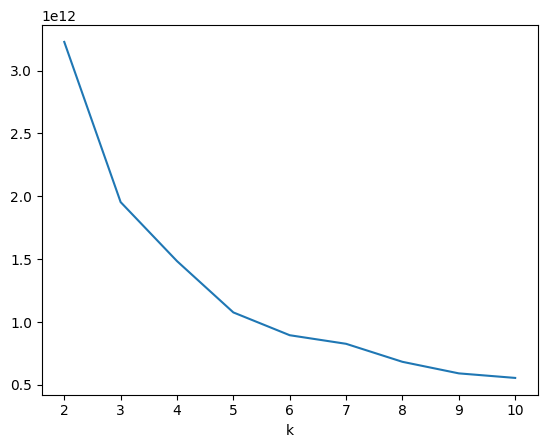

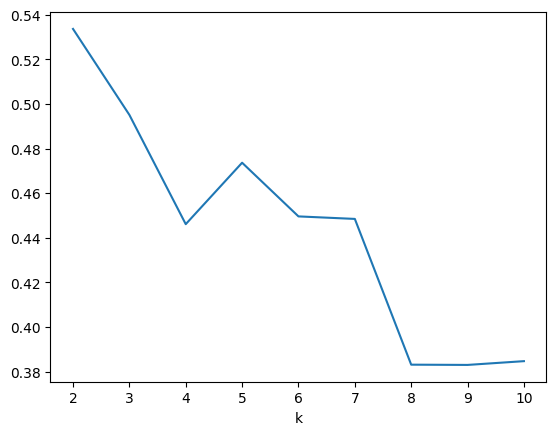

In [154]:
X = df_encoded.values

clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.figure()
df_clustering_scores.silhouette.plot()

According to the SSE and Silhouette score I have diceded to choose 5 clusters

In [155]:
clustering = sklearn.cluster.KMeans(n_clusters = 5)
clustering.fit(X)

KMeans(n_clusters=5)

In [156]:
pd.Series(clustering.labels_).value_counts()

,count
3,4140
2,3296
1,1869
0,744
4,619


There are two large clusters, one medium-sized cluster, and two smaller clusters.

In [157]:
df_encoded["cluster_id"] = clustering.labels_
df_encoded.head()

,year,price,mileage,tax,mpg,engineSize,model_ A1,model_ A2,model_ A3,model_ A4,...,model_ SQ5,model_ SQ7,model_ TT,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol,cluster_id
0,2017,12500,15735,150,55.4,1.4,True,False,False,False,...,False,False,False,False,True,False,False,False,True,2
1,2016,16500,36203,20,64.2,2.0,False,False,False,False,...,False,False,False,True,False,False,True,False,False,2
2,2016,11000,29946,30,55.4,1.4,True,False,False,False,...,False,False,False,False,True,False,False,False,True,2
3,2017,16800,25952,145,67.3,2.0,False,False,False,True,...,False,False,False,True,False,False,True,False,False,2
4,2019,17300,1998,145,49.6,1.0,False,False,True,False,...,False,False,False,False,True,False,False,False,True,3


Description of each cluster

In [158]:
with pd.option_context('display.max_columns', None):
    display(df_encoded.groupby('cluster_id').describe())

year                                                         \
             count         mean       std     min     25%     50%     75%   
cluster_id                                                                  
0            744.0  2018.834677  1.039376  2013.0  2019.0  2019.0  2019.0   
1           1869.0  2015.200107  1.577607  1998.0  2014.0  2016.0  2016.0   
2           3296.0  2016.365595  1.118537  2004.0  2016.0  2016.0  2017.0   
3           4140.0  2018.798792  0.876720  2014.0  2019.0  2019.0  2019.0   
4            619.0  2013.311793  3.054209  1997.0  2012.0  2014.0  2015.0   

                     price                                                \
               max   count          mean           std      min      25%   
cluster_id                                                                 
0           2020.0   744.0  52768.721774  14523.821583  38799.0  44500.0   
1           2019.0  1869.0  15619.311396   5706.722274   4999.0  11980.0   
2           2020.0  3296.0  17809.008799   5070.451660   4689.0  14216.5   
3           2020.0  4140.0  26739.457488   5908.375559  10985.0  22000.0   
4           2017.0   619.0  10354.712439   4111.316079   1490.0   7791.0   

                                       mileage                              \
                50%      75%       max   count          mean           std   
cluster_id                                                                   
0           49000.0  55073.0  145000.0   744.0   8435.071237   8195.661668   
1           14990.0  17790.0   52000.0  1869.0  49673.722846   8420.907672   
2           17444.5  19999.0   45790.0  3296.0  26064.947816   6480.669947   
3           26495.0  30998.5   40000.0  4140.0   6128.662077   4243.009529   
4            9999.0  12747.5   28990.0   619.0  87978.075929  19010.397762   

                                                               tax  \
                min       25%      50%       75%       max   count   
cluster_id                                                           
0               1.0   3006.00   6000.0  10202.50   41854.0   744.0   
1           37141.0  42318.00  48194.0  55827.00   69682.0  1869.0   
2           11578.0  20825.75  26051.0  31208.25   40000.0  3296.0   
3               5.0   3000.00   5150.0   8761.50   22216.0  4140.0   
4           68446.0  75172.00  83000.0  95000.00  323000.0   619.0   

                                                                          mpg  \
                  mean         std    min    25%    50%    75%    max   count   
cluster_id                                                                      
0           157.043011   58.624827  135.0  145.0  145.0  145.0  580.0   744.0   
1           109.571964   94.143574    0.0   30.0  125.0  160.0  580.0  1869.0   
2           109.000303   71.864569    0.0   30.0  145.0  150.0  570.0  3296.0   
3           143.683575   19.019360    0.0  145.0  145.0  145.0  300.0  4140.0   
4           110.735057  105.596936    0.0   20.0  125.0  165.0  570.0   619.0   

                                                                engineSize  \
                 mean        std   min   25%   50%   75%    max      count   
cluster_id                                                                   
0           35.929032  12.601691  19.6  32.5  33.2  38.2  117.7      744.0   
1           57.389567  12.726036  20.3  48.7  57.6  65.7  188.3     1869.0   
2           56.432130  11.076920  21.0  49.6  55.4  62.8  188.3     3296.0   
3           44.808068   8.185336  30.1  39.2  44.1  49.6  188.3     4140.0   
4           58.346688  15.712779  18.9  48.7  58.9  67.3  176.6      619.0   

                                                         
                mean       std  min  25%  50%  75%  max  
cluster_id                                               
0           3.097849  0.694970  0.0  3.0  3.0  3.0  5.2  
1           2.000696  0.555105  0.0  1.6  2.0  2.0  4.2  
2           1.779126  0.507116  0.0  1

In [159]:
# Summing one-hot encoded columns for each cluster
fuel_counts = df_encoded.groupby('cluster_id')[['fuelType_Diesel', 'fuelType_Petrol', 'fuelType_Hybrid']].sum()
print(fuel_counts)



            fuelType_Diesel  fuelType_Petrol  fuelType_Hybrid
cluster_id                                                   
0                       546              186               12
1                      1335              529                5
2                      1457             1835                4
3                      1708             2429                3
4                       531               84                4


In [160]:
# Summing one-hot encoded columns for each cluster
transmission_counts = df_encoded.groupby('cluster_id')[['transmission_Automatic', 'transmission_Manual', 'transmission_Semi-Auto']].sum()
print(transmission_counts)

            transmission_Automatic  transmission_Manual  \
cluster_id                                                
0                              382                    1   
1                              373                  952   
2                              493                 1815   
3                             1293                 1209   
4                              167                  392   

            transmission_Semi-Auto  
cluster_id                          
0                              361  
1                              544  
2                              988  
3                             1638  
4                               60  


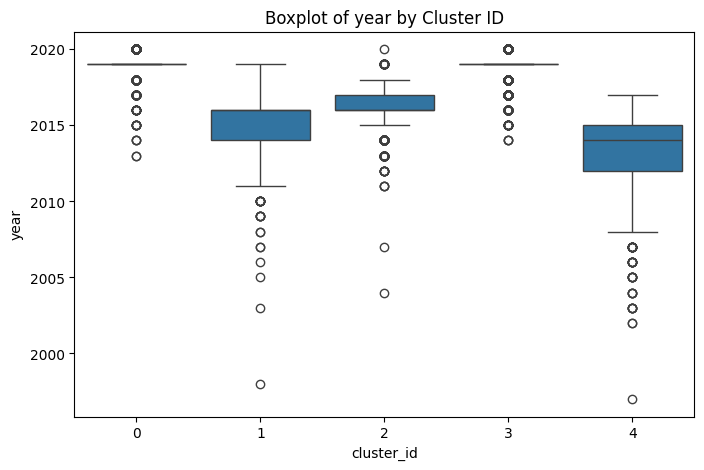

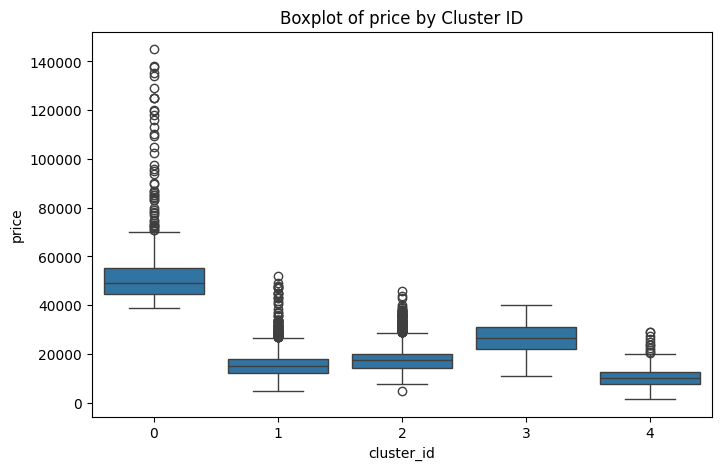

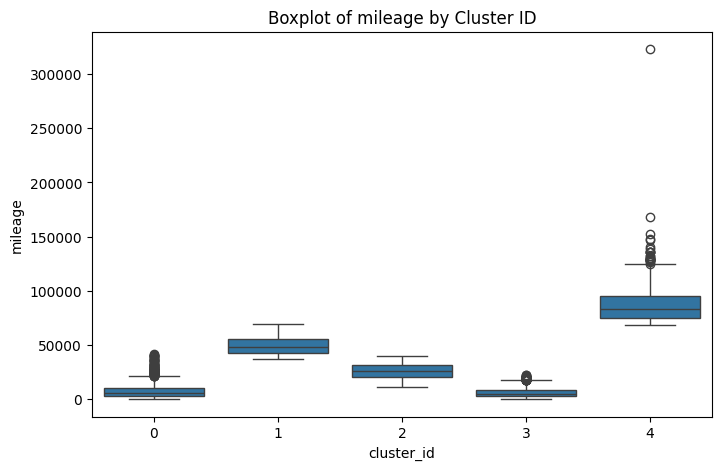

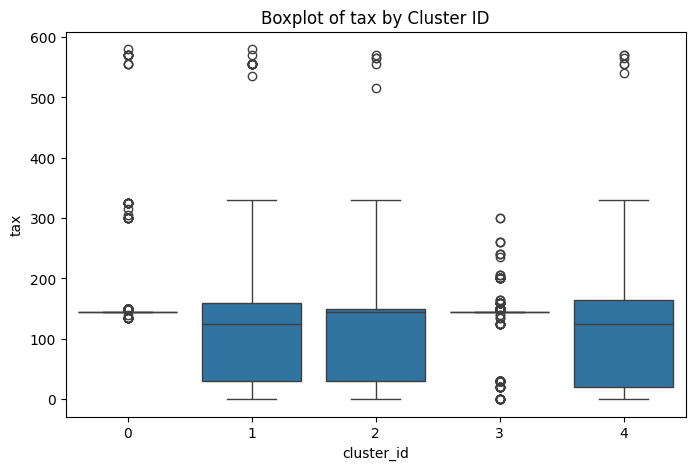

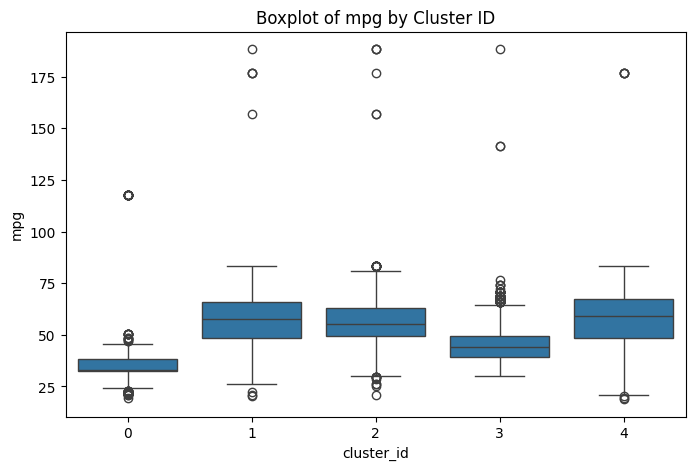

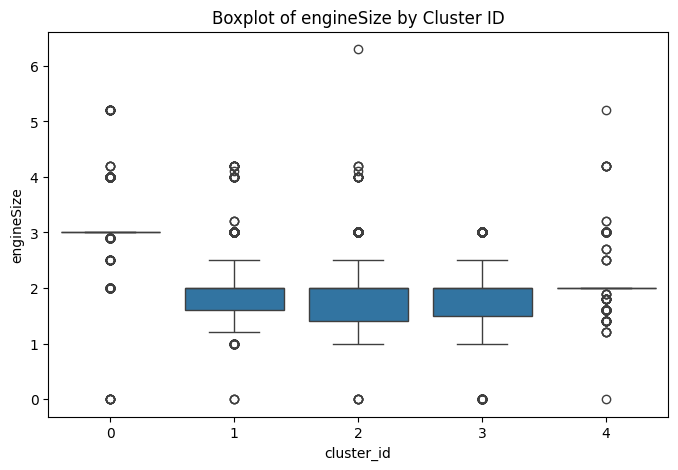

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

features_to_display = ["year", "price", "mileage", "tax", "mpg", "engineSize"]

for f in features_to_display:
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(data=df_encoded, x="cluster_id", y=f)
    plt.title(f"Boxplot of {f} by Cluster ID")

    plt.show()

**Cluster 0**<br>
This cluster consists of cars that are moderately priced, with a registration year around the middle range. The mileage is on the higher end, and more than half of the cars in this cluster are diesel-powered, suggesting they are older models with higher usage. The average engine size is 2.0, and the fuel efficiency (MPG) is similar to clusters 2 and 3.

**Cluster 1**<br>
Cluster 1 features newer cars with low mileage, averaging a larger engine size of 3.0 compared to other clusters. These cars have the lowest fuel efficiency (MPG) and are priced higher, with an average price of around 50k. This cluster may represent higher-end or luxury vehicles with fewer miles and larger engines.

**Cluster 2**<br>
The cars in Cluster 2 are typically the oldest and least expensive, with an average price around 10k. They also have the highest mileage, and most are diesel-powered. The average registration year is 2014, indicating this cluster contains older models that have seen significant use, offering lower prices as a result.

**Cluster 3**<br>
Cars in Cluster 3 are of average age, with a moderate registration year and decent mileage. The prices in this cluster are reasonable, and more than half of the cars have manual transmissions. The engine size is typically 2.0, and the MPG is similar to Clusters 0 and 2, suggesting they strike a balance between age, condition, and performance.

**Cluster 4**<br>
Cluster 4 includes new cars with low mileage, similar to Cluster 1, but with better fuel efficiency (MPG) and lower prices. The engine size is also smaller, and the transmission types are more balanced across automatic, manual, and semi-automatic. These cars are likely to appeal to those seeking newer models with a balance of economy and price.



#### HDBSCAN

In [174]:
df_encoded_hdbscan = df.copy()
df_encoded_hdbscan = pd.get_dummies(df)

In [175]:
features = df_encoded_hdbscan[['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [192]:
# Initialize HDBSCAN clusterer
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1000)

# Fit and predict clusters
cluster_labels = clusterer.fit_predict(scaled_features)

In [193]:
df_encoded_hdbscan['hdbscan_cluster'] = cluster_labels

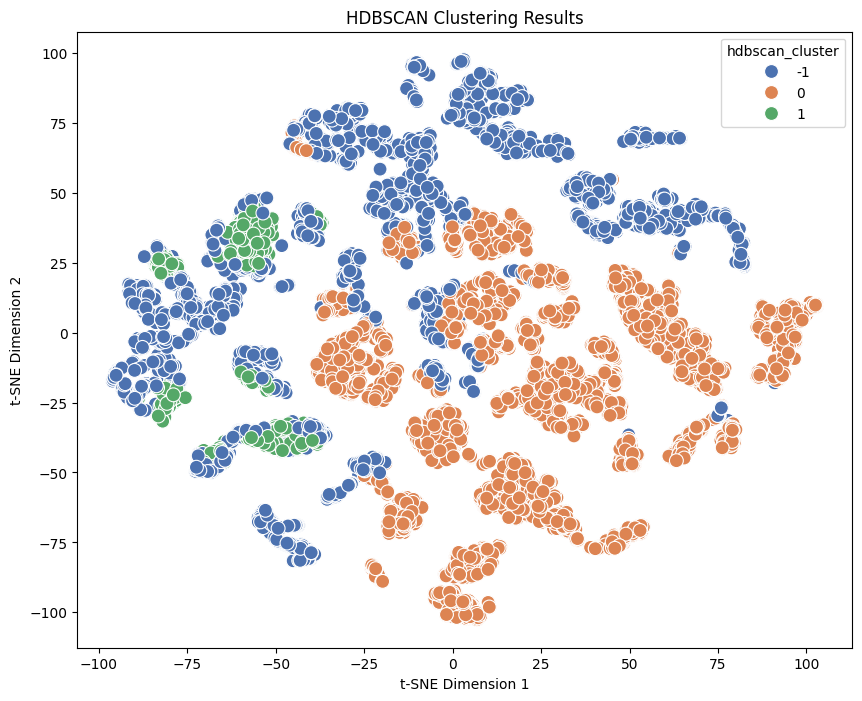

In [194]:
# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(scaled_features)

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_encoded_hdbscan['hdbscan_cluster'], palette='deep', s=100)
plt.title('HDBSCAN Clustering Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [195]:
cluster_counts = df_encoded_hdbscan['hdbscan_cluster'].value_counts()
print(cluster_counts)

hdbscan_cluster
 0    5398
-1    4511
 1     759
Name: count, dtype: int64


In [196]:
cluster_means = df_encoded_hdbscan.groupby('hdbscan_cluster').mean()
print(cluster_means)

                        year         price       mileage         tax  \
hdbscan_cluster                                                        
-1               2015.871204  22281.476834  38708.225449  118.718688   
 0               2018.298073  24548.277881  12083.552983  146.105965   
 1               2015.891963  14806.969697  32960.757576   26.442688   

                       mpg  engineSize  model_ A1  model_ A2  model_ A3  \
hdbscan_cluster                                                           
-1               53.930703    2.172290   0.166039   0.000222   0.163378   
 0               46.441941    1.759207   0.081697   0.000000   0.166914   
 1               62.766271    1.714625   0.206851   0.000000   0.383399   

                 model_ A4  ...  model_ S8  model_ SQ5  model_ SQ7  model_ TT  \
hdbscan_cluster             ...                                                 
-1                0.133673  ...   0.000887    0.003547    0.001773   0.026380   
 0                0.

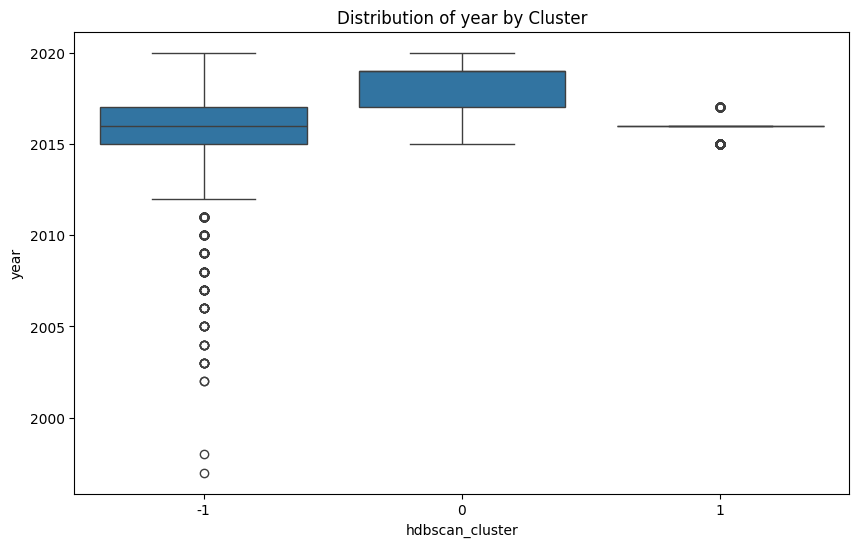

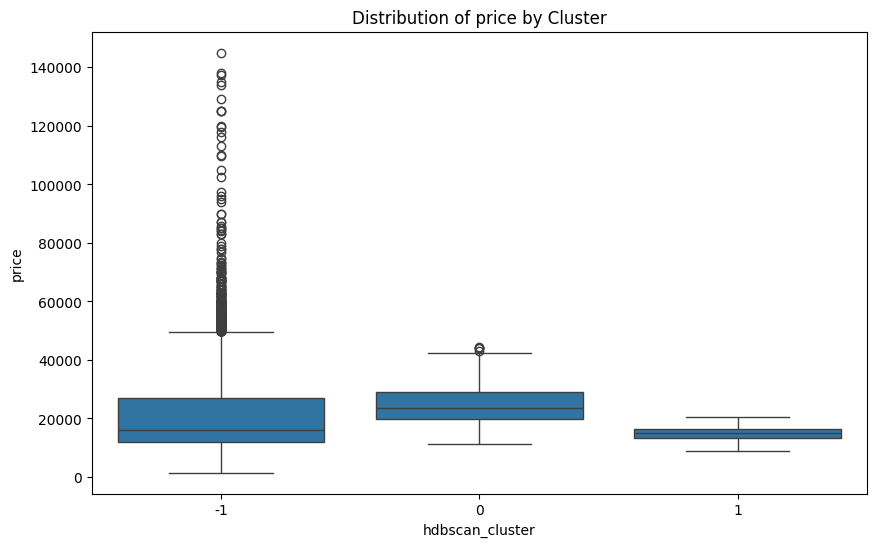

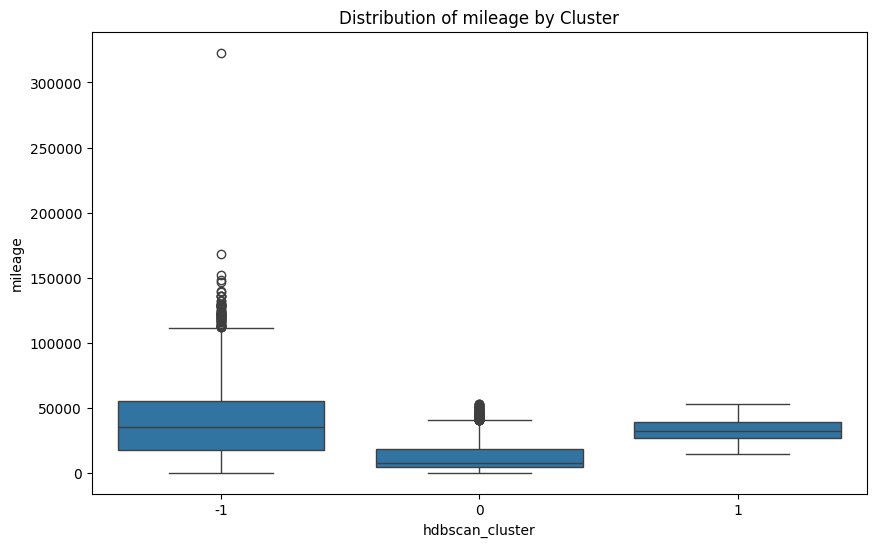

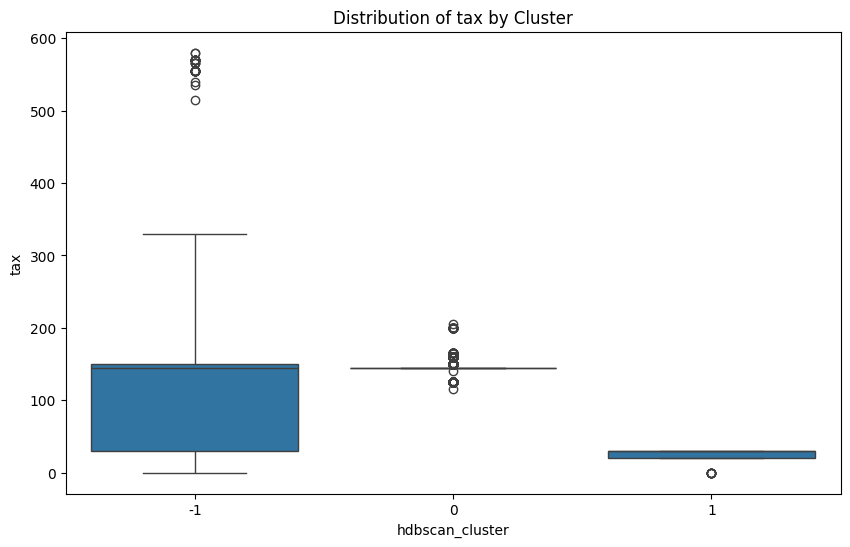

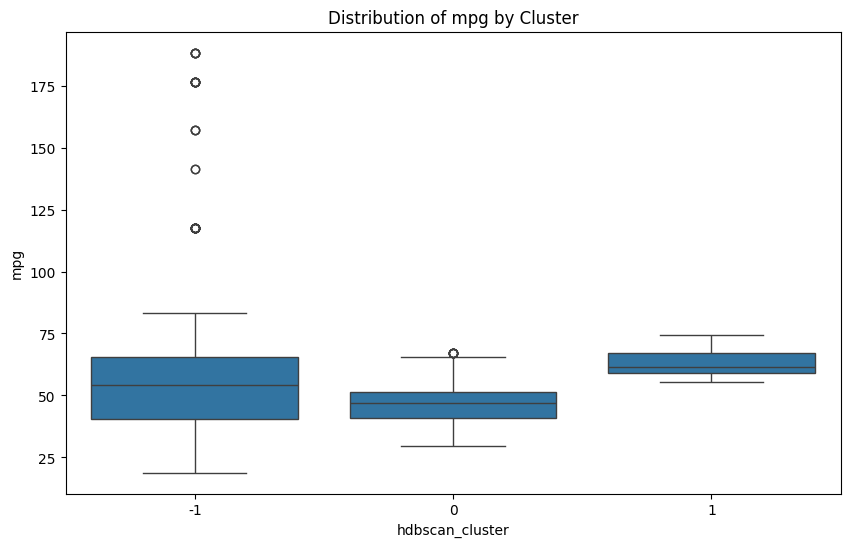

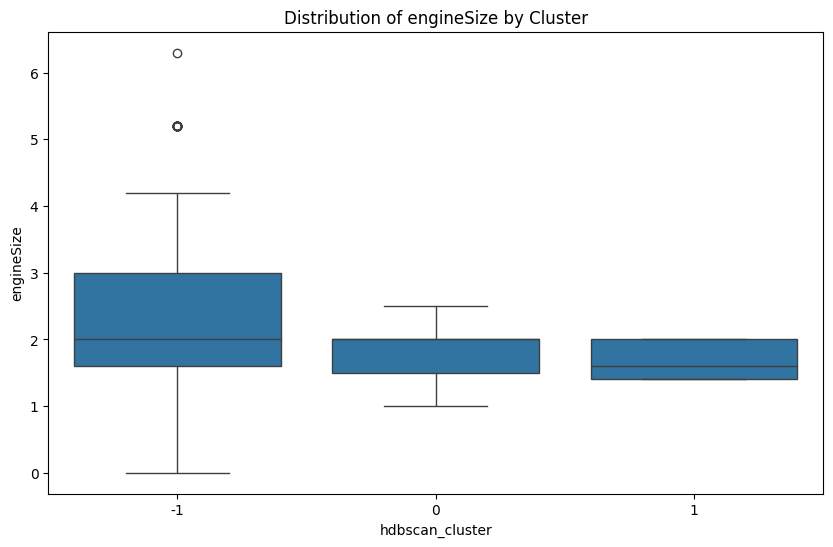

In [197]:
features = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_encoded_hdbscan['hdbscan_cluster'], y=df_encoded_hdbscan[feature])
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

**Cluster -1**<br>
Represents outliers or noise, with mixed characteristics in terms of car age, mileage, price, and fuel type. These cars do not fit neatly into other clusters.

**Cluster 0**<br>
Consists of newer cars (average year 2018) with low mileage and relatively high prices. These cars are mostly Diesel, with small engine sizes and a mix of automatic and semi-automatic transmissions.

**Cluster 1**<br>
Includes older cars (average year 2015) with high mileage and low prices. They are primarily Diesel, have manual transmissions, and are fuel-efficient, averaging a high mpg.